##### Zadanie Domowe

Poniżej podany jest zestaw danych. Zawiera on brakujące wartości. Twoim zadaniem jest przygotować ten zestaw danych do obróbki a następnie wytrenować klasyfikator przewidujący choroby serca dobierając ilość kroków oraz learning rate.

Wartością docelową jest `num`

Twoim celem jest odrzucenie zmiennych charakteryzujących się dużą ilością wartości brakujących oraz uzupełnienie pozostałych kolumn. Użyj do tego na przykład funkcji `pd.DataFrame.isna`, `pd.DataFrame.sum` oraz metody `pd.Series.fillna`.

Użyj metody `xgb.cv` do ustalenia przebiegu treningu. Postaraj się dobrać takie wartości ilości kroków oraz learning rate aby uniknąć przeuczenia (overfitu) w końcowym modelu. Zacznij od learning rate `0.01`. Kiedy klasyfikator zostanie przetrenowany, użyj wykresu błędu w zależności od ilości kroków aby wyznaczyć przybliżoną optymalną ilość drzew dla danego modelu i wytrenuj ostateczny model.

Dodatkowe info: `xgb` obsługuje brakujące wartości przez parametr `missing`. Możesz (nie musisz) użyć tego zamiast interpolacji brakujących wartości.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


data = pd.read_csv("heart.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         294 non-null    int64  
 1   sex         294 non-null    int64  
 2   cp          294 non-null    int64  
 3   trestbps    294 non-null    object 
 4   chol        294 non-null    object 
 5   fbs         294 non-null    object 
 6   restecg     294 non-null    object 
 7   thalach     294 non-null    object 
 8   exang       294 non-null    object 
 9   oldpeak     294 non-null    float64
 10  slope       294 non-null    object 
 11  ca          294 non-null    object 
 12  thal        294 non-null    object 
 13  num         294 non-null    int64  
dtypes: float64(1), int64(4), object(9)
memory usage: 32.3+ KB


294 rekordy - 14 kolumn

Rozumienie bazy danych:


age: wiek w latach

sex: płeć 

cp: rodzaj bólu w klatce piersiowej 

trestbps: spoczynkowe ciśnienie krwi (w mm Hg przy przyjęciu do szpitala)

chol: poziom cholesterolu we krwi w mg/dl

fbs: poziom glukozy na czczo > 120 mg/dl

restecg: wyniki spoczynkowego elektrokardiogramu 

thalach: maksymalna osiągnięta częstość akcji serca

exang: dusznica wysiłkowa 

oldpeak: spadek odcinka ST spowodowany wysiłkiem w stosunku do spoczynku

slope: nachylenie szczytowego odcinka ST podczas wysiłku 

ca: liczba głównych naczyń, które są widoczne podczas fluoroskopii

thal: Thalassemia - zaburzenie krwi

num: diagnoza choroby serca 


### 1. WSTĘPNA ANALIZA DANYCH:

In [2]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,28,1,2,130,132,0,2,185,0,0.0,?,?,?,0
1,29,1,2,120,243,0,0,160,0,0.0,?,?,?,0
2,29,1,2,140,?,0,0,170,0,0.0,?,?,?,0
3,30,0,1,170,237,0,1,170,0,0.0,?,?,6,0
4,31,0,2,100,219,0,1,150,0,0.0,?,?,?,0


In [3]:
data.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
289,52,1,4,160,331,0,0,94,1,2.5,?,?,?,1
290,54,0,3,130,294,0,1,100,1,0.0,2,?,?,1
291,56,1,4,155,342,1,0,150,1,3.0,2,?,?,1
292,58,0,2,180,393,0,0,110,1,1.0,2,?,7,1
293,65,1,4,130,275,0,1,115,1,1.0,2,?,?,1


In [4]:
data.describe()

,age,sex,cp,oldpeak,num
count,294.000000,294.000000,294.000000,294.000000,294.000000
mean,47.826531,0.724490,2.982993,0.586054,0.360544
std,7.811812,0.447533,0.965117,0.908648,0.480977
min,28.000000,0.000000,1.000000,0.000000,0.000000
25%,42.000000,0.000000,2.000000,0.000000,0.000000
50%,49.000000,1.000000,3.000000,0.000000,0.000000
75%,54.000000,1.000000,4.000000,1.000000,1.000000
max,66.000000,1.000000,4.000000,5.000000,1.000000


In [5]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num       '],
      dtype='object')

### 2. PRZYGOTOWANIE DANYCH

zmieniam nazwe kolumny num usuwajac spacje, żeby nie było błędów:

In [6]:
data = data.rename(columns={'num       ': 'num'})

In [7]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'],
      dtype='object')

In [8]:
cols=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

In [9]:
for i in cols:
    print(f'Liczba kategorii zmiennej {i}: \n {data[i].value_counts()}')

Liczba kategorii zmiennej age: 
 age
54    25
48    19
52    17
55    15
49    15
46    13
53    12
50    12
43    12
39    11
41    11
47    10
56    10
58     9
51     9
59     8
45     8
37     8
42     7
40     7
38     7
44     7
36     5
35     5
57     5
34     4
32     4
65     3
61     2
60     2
62     2
31     2
33     2
29     2
63     1
28     1
30     1
66     1
Name: count, dtype: int64
Liczba kategorii zmiennej sex: 
 sex
1    213
0     81
Name: count, dtype: int64
Liczba kategorii zmiennej cp: 
 cp
4    123
2    106
3     54
1     11
Name: count, dtype: int64
Liczba kategorii zmiennej trestbps: 
 trestbps
120    65
130    54
140    50
150    23
110    21
160    20
125     8
180     6
100     6
145     5
170     5
135     5
112     3
115     2
124     2
118     2
122     2
105     1
92      1
128     1
136     1
138     1
200     1
106     1
108     1
113     1
98      1
?       1
132     1
142     1
190     1
155     1
Name: count, dtype: int64
Liczba kategorii zmienne

SPRAWDZMY CZY MAMY NULLE

In [10]:
print("Null value counts in each column:")
print(data.isna().sum())

Null value counts in each column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64


Nie ma nulli ale są '?'

In [11]:
for column in data.columns:
    count = data[column][data[column] == '?'].count()
    print(f"Kolumna '{column}' ma {count} wystąpień '?'")

Kolumna 'age' ma 0 wystąpień '?'
Kolumna 'sex' ma 0 wystąpień '?'
Kolumna 'cp' ma 0 wystąpień '?'
Kolumna 'trestbps' ma 1 wystąpień '?'
Kolumna 'chol' ma 23 wystąpień '?'
Kolumna 'fbs' ma 8 wystąpień '?'
Kolumna 'restecg' ma 1 wystąpień '?'
Kolumna 'thalach' ma 1 wystąpień '?'
Kolumna 'exang' ma 1 wystąpień '?'
Kolumna 'oldpeak' ma 0 wystąpień '?'
Kolumna 'slope' ma 190 wystąpień '?'
Kolumna 'ca' ma 291 wystąpień '?'
Kolumna 'thal' ma 266 wystąpień '?'
Kolumna 'num' ma 0 wystąpień '?'


Kolumna 'slope', 'ca', 'thal' mają bardzo dużo braków. Ponad 60%.

USUWAMY TE KOLUMNY

In [12]:
df = data.drop(columns=['slope', 'ca', 'thal'])

In [13]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,num
0,28,1,2,130,132,0,2,185,0,0.0,0
1,29,1,2,120,243,0,0,160,0,0.0,0
2,29,1,2,140,?,0,0,170,0,0.0,0
3,30,0,1,170,237,0,1,170,0,0.0,0
4,31,0,2,100,219,0,1,150,0,0.0,0


In [14]:
df = df.replace('?', pd.NA)

In [15]:
print("Null value counts in each column:")
print(df.isna().sum())

Null value counts in each column:
age          0
sex          0
cp           0
trestbps     1
chol        23
fbs          8
restecg      1
thalach      1
exang        1
oldpeak      0
num          0
dtype: int64


In [16]:
print(df[df['trestbps'].isna()])

    age  sex  cp trestbps chol fbs restecg thalach exang  oldpeak  num
90   48    0   2     <NA>  308   0       1    <NA>  <NA>      2.0    0


Trestbps, thalach i exang - dla jednego rekordu wszystkie maja brak wartosci. I target jest 0. Usuwam ten rekord.

In [17]:
df = df.dropna(subset=['trestbps'])

In [18]:
print(df.isna().sum())

age          0
sex          0
cp           0
trestbps     0
chol        23
fbs          8
restecg      1
thalach      0
exang        0
oldpeak      0
num          0
dtype: int64


In [19]:
print(df[df['restecg'].isna()])

     age  sex  cp trestbps chol fbs restecg thalach exang  oldpeak  num
268   55    1   1      140  295   0    <NA>     136     0      0.0    1


In [20]:
print(df[df['trestbps'].isna()])

Empty DataFrame
Columns: [age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpeak, num]
Index: []


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, 0 to 293
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       293 non-null    int64  
 1   sex       293 non-null    int64  
 2   cp        293 non-null    int64  
 3   trestbps  293 non-null    object 
 4   chol      270 non-null    object 
 5   fbs       285 non-null    object 
 6   restecg   292 non-null    object 
 7   thalach   293 non-null    object 
 8   exang     293 non-null    object 
 9   oldpeak   293 non-null    float64
 10  num       293 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 27.5+ KB


In [22]:
df[['trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang']] = df[['trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang']].apply(pd.to_numeric, errors='coerce')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 293 entries, 0 to 293
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       293 non-null    int64  
 1   sex       293 non-null    int64  
 2   cp        293 non-null    int64  
 3   trestbps  293 non-null    int64  
 4   chol      270 non-null    float64
 5   fbs       285 non-null    float64
 6   restecg   292 non-null    float64
 7   thalach   293 non-null    int64  
 8   exang     293 non-null    int64  
 9   oldpeak   293 non-null    float64
 10  num       293 non-null    int64  
dtypes: float64(4), int64(7)
memory usage: 27.5 KB


Sprawdzmy jak nasze bazy wygladaja na wykresach:

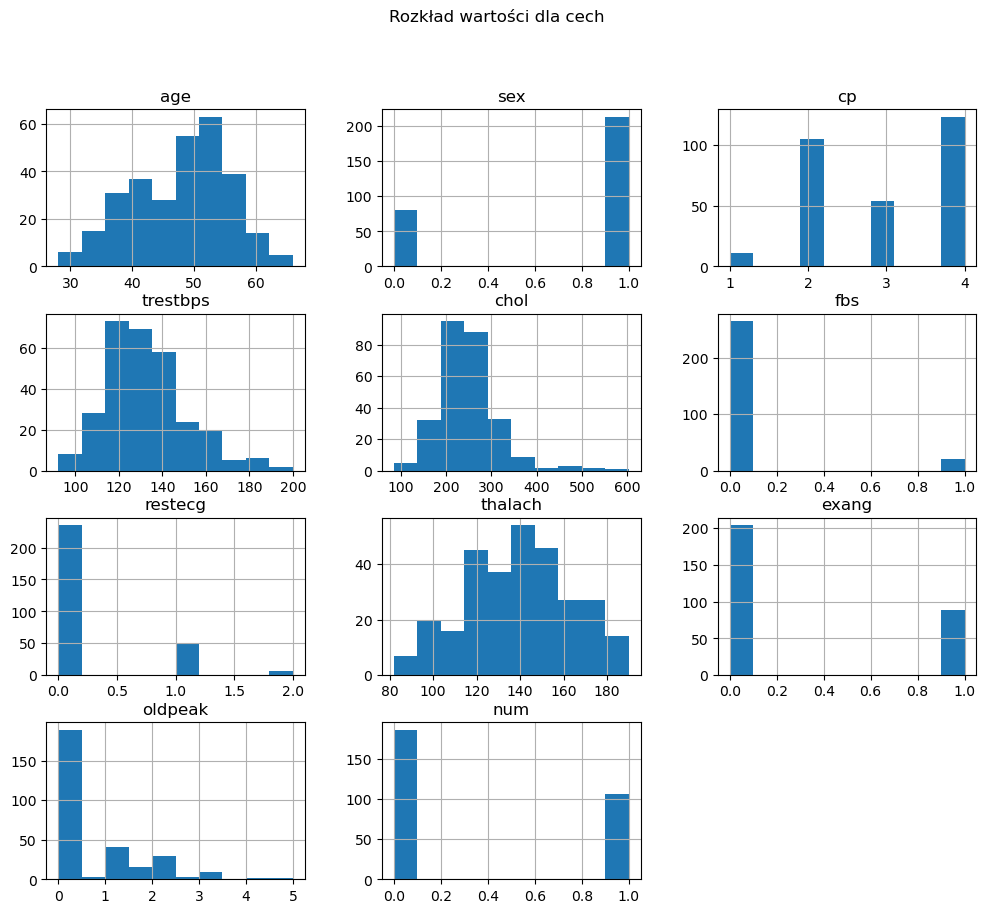

In [24]:
df.hist(figsize=(12, 10))
plt.suptitle('Rozkład wartości dla cech')
plt.show()

Uzupełnijmy brakujące dane

In [25]:
#data_filled = data.fillna(data.median())

### 3. PODZIAŁ NA ZBIÓR TESTOWY I TRENINGOWY:

In [26]:
X = df.drop('num', axis=1)
y = df['num']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(234, 10)
(59, 10)
(234,)
(59,)


### 3. TRENING MODELU:

In [29]:
dtrain = xgb.DMatrix(X_train, label=y_train, missing=np.nan)
dtest = xgb.DMatrix(X_test, label=y_test, missing=np.nan)

Parametry, które chcemy dobrać najlepsze:

In [30]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9],
    'num_boost_round': [100, 300, 500, 1000]
}


Stałe parametry:

In [31]:
params_base = {
    'objective': 'binary:logistic',
    'eval_metric': 'error'
}

In [32]:
cv_results_list = []

for params in ParameterGrid(param_grid):

    params_combined = {**params_base, **params}
    
    num_boost_round = params_combined.pop('num_boost_round')
    
    cv_results = xgb.cv(
        params=params_combined,
        dtrain=dtrain,
        num_boost_round=num_boost_round,
        nfold=5,
        metrics={'error'},
        early_stopping_rounds=50,
        as_pandas=True,
        seed=42
    )

    best_num_boost_round = cv_results['test-error-mean'].argmin()
    best_error = cv_results['test-error-mean'].min()
    cv_results_list.append((params_combined, best_num_boost_round, best_error))


In [33]:
best_params, best_num_boost_round, best_error = min(cv_results_list, key=lambda x: x[2])
print(f'Najlepsze parametry: {best_params}')
print(f'Ilość kroków: {best_num_boost_round}')
print(f'Najlepsza wartość błędu: {best_error}')

Najlepsze parametry: {'objective': 'binary:logistic', 'eval_metric': 'error', 'learning_rate': 0.01, 'max_depth': 3}
Ilość kroków: 111
Najlepsza wartość błędu: 0.18825161887141534


In [34]:
final_model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=best_num_boost_round
)

In [35]:
y_pred_train = final_model.predict(dtrain)

In [36]:
y_pred_class_train = (y_pred_train >= 0.5).astype(int)

In [37]:
accuracy_train = accuracy_score(y_train, y_pred_class_train)
print(f'Training Accuracy: {accuracy_train}')

error_train = 1 - accuracy_train
print(f'Training Error: {error_train}')

Training Accuracy: 0.8547008547008547
Training Error: 0.14529914529914534


In [41]:
y_pred_test = final_model.predict(dtest)

In [42]:
y_pred_class_test = (y_pred_test >= 0.5).astype(int)

In [43]:
accuracy_test= accuracy_score(y_test, y_pred_class_test)
print(f'Test Accuracy: {accuracy_test}')

error_test = 1 - accuracy_test
print(f'Test Error: {error_test}')

Test Accuracy: 0.8135593220338984
Test Error: 0.18644067796610164


In [44]:
cv_results = xgb.cv(
    params=best_params,
    dtrain=dtrain,
    num_boost_round=1000,
    nfold=5,
    metrics={'error'},
    early_stopping_rounds=50,
    seed=42
)

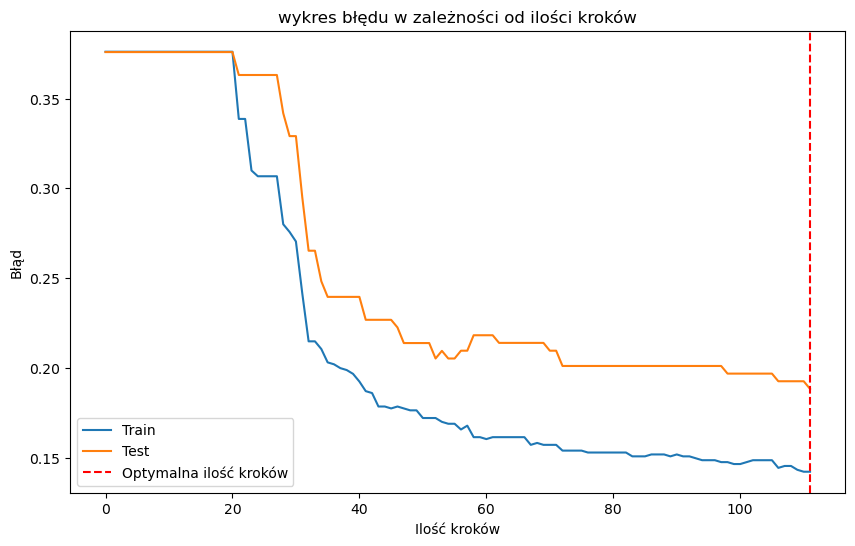

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(cv_results['train-error-mean'], label='Train')
plt.plot(cv_results['test-error-mean'], label='Test')
plt.axvline(best_num_boost_round, color='red', linestyle='--', label='Optymalna ilość kroków')
plt.xlabel('Ilość kroków')
plt.ylabel('Błąd')
plt.legend()
plt.title('wykres błędu w zależności od ilości kroków')
plt.show()

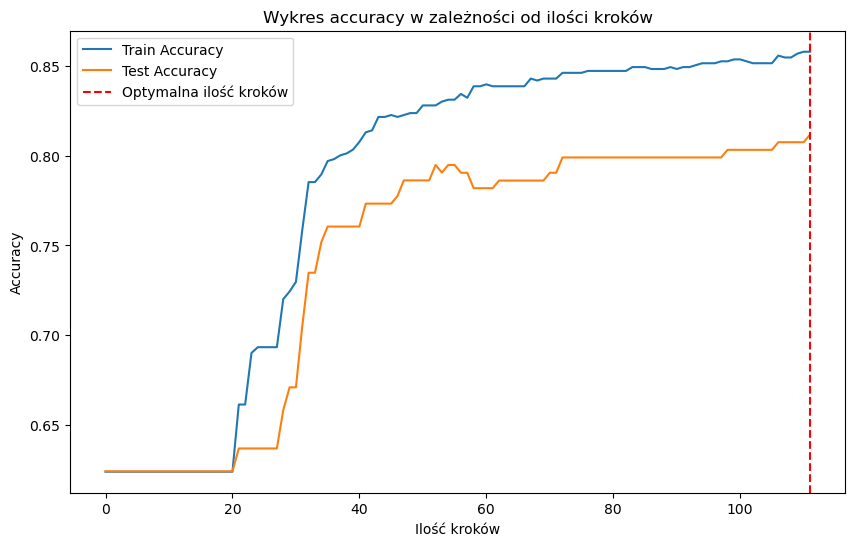

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(1 - cv_results['train-error-mean'], label='Train Accuracy')
plt.plot(1 - cv_results['test-error-mean'], label='Test Accuracy')
plt.axvline(best_num_boost_round, color='red', linestyle='--', label='Optymalna ilość kroków')
plt.xlabel('Ilość kroków')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Wykres accuracy w zależności od ilości kroków')
plt.show()

### Najlepsze parametry to: learning_rate: 0.01, max_depth: 3, num_boost_round: 111

Training Accuracy: 0.8547008547008547

Training Error: 0.14529914529914534

Test Accuracy: 0.8135593220338984

Test Error: 0.18644067796610164